# Imports

In [2]:
# System Imports
import os
import time

# Data Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import helper_functions as hf

# Deep Learning Framework
import tensorflow as tf

# SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
for device in tf.config.list_physical_devices('GPU'):
    print(f"* {device}")

* PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Reading in Images

In [4]:
# Setting paths

train_data_path = './data/archive/train'
test_data_path = './data/archive/test'

In [5]:
# Viewing categories

categories = os.listdir(train_data_path)
print(f"The categories are: {categories}")

The categories are: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [6]:
# Configurations

SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20
EPOCHS = 10

In [7]:
# Creating the training set

training_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.
Metal device set to: Apple M1


2022-12-11 15:07:49.328587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 15:07:49.328723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Creating the validation set

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


## Plotting Images

2022-12-11 14:57:07.093569: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


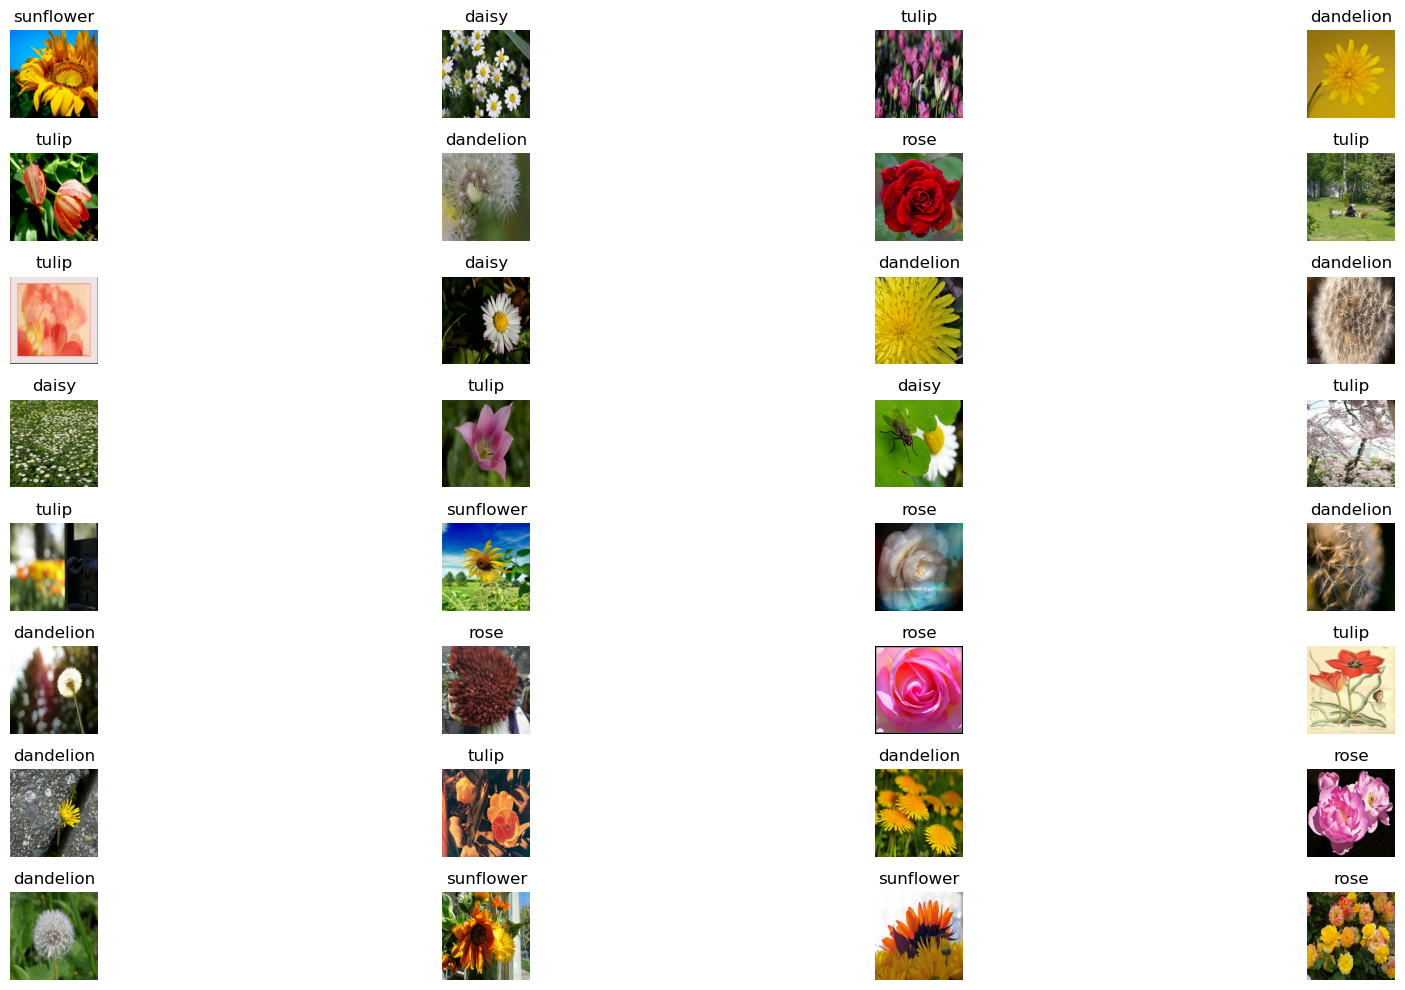

In [8]:
# Plotting some images

hf.plot_images(training_set, categories)

# Modeling

In [18]:
# Function that creates a model

def get_baseline_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)): 

    ## Clearing backend
    tf.keras.backend.clear_session()

    ## Input Layer
    inputs = tf.keras.Input(shape=(input_shape))

    # Rescaling the images
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    ## First CNN
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Second CNN
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Third CNN
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Flatten layer
    x = tf.keras.layers.Flatten()(x)

    ## First Dense layer
    x = tf.keras.layers.Dense(
        units=64,
        activation='relu'
    )(x)

    ## Output
    outputs = tf.keras.layers.Dense(
        units=len(categories),
        activation='softmax'
    )(x)

    ## Creating Model
    model = tf.keras.Model(
        inputs=inputs,
        outputs=outputs
    )

    ## Compiling the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    ## Viewing the architecture
    model.summary()

    return model

In [10]:
model_elapsed_time = {}

In [11]:
# Training the model

start_time = time.time()

baseline_model = get_baseline_model()

history = baseline_model.fit(
  training_set,
  validation_data=validation_set,
  epochs=EPOCHS
)

elasped_time = time.time() - start_time
model_elapsed_time["baseline"] = elasped_time

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

2022-12-11 14:57:09.112056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 1.3089 - accuracy: 0.4342

2022-12-11 14:57:32.824264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 26s 373ms/step - loss: 1.3089 - accuracy: 0.4342 - val_loss: 1.1304 - val_accuracy: 0.4863
Epoch 2/10
69/69 [==============================] - 26s 377ms/step - loss: 1.0027 - accuracy: 0.5990 - val_loss: 1.0047 - val_accuracy: 0.6175
Epoch 3/10
69/69 [==============================] - 27s 388ms/step - loss: 0.7785 - accuracy: 0.7028 - val_loss: 1.0908 - val_accuracy: 0.5993
Epoch 4/10
69/69 [==============================] - 24s 348ms/step - loss: 0.5576 - accuracy: 0.7961 - val_loss: 1.0605 - val_accuracy: 0.6539
Epoch 5/10
69/69 [==============================] - 24s 345ms/step - loss: 0.3666 - accuracy: 0.8694 - val_loss: 1.3877 - val_accuracy: 0.5902
Epoch 6/10
69/69 [==============================] - 22s 323ms/step - loss: 0.1892 - accuracy: 0.9358 - val_loss: 1.4280 - val_accuracy: 0.6448
Epoch 7/10
69/69 [==============================] - 22s 320ms/step - loss: 0.1137 - accuracy: 0.9654 - val_loss: 1.8201 - val_accuracy: 0.6393
Epoch 8/10

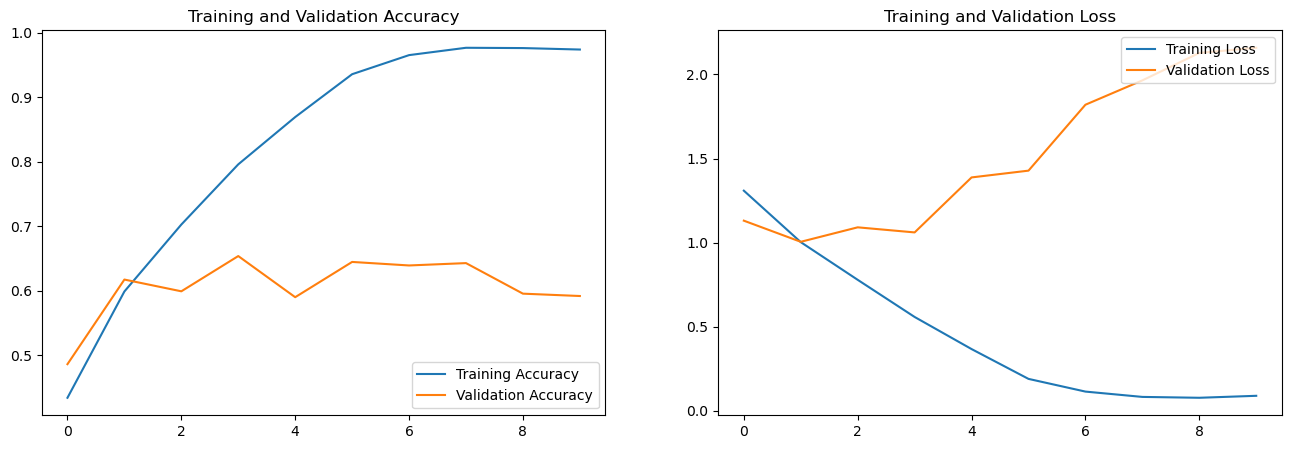

In [12]:
# Viewing the results of the training

hf.plot_history(history)

1/1 [==============================] - 0s 15ms/step


2022-12-11 15:01:11.040132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


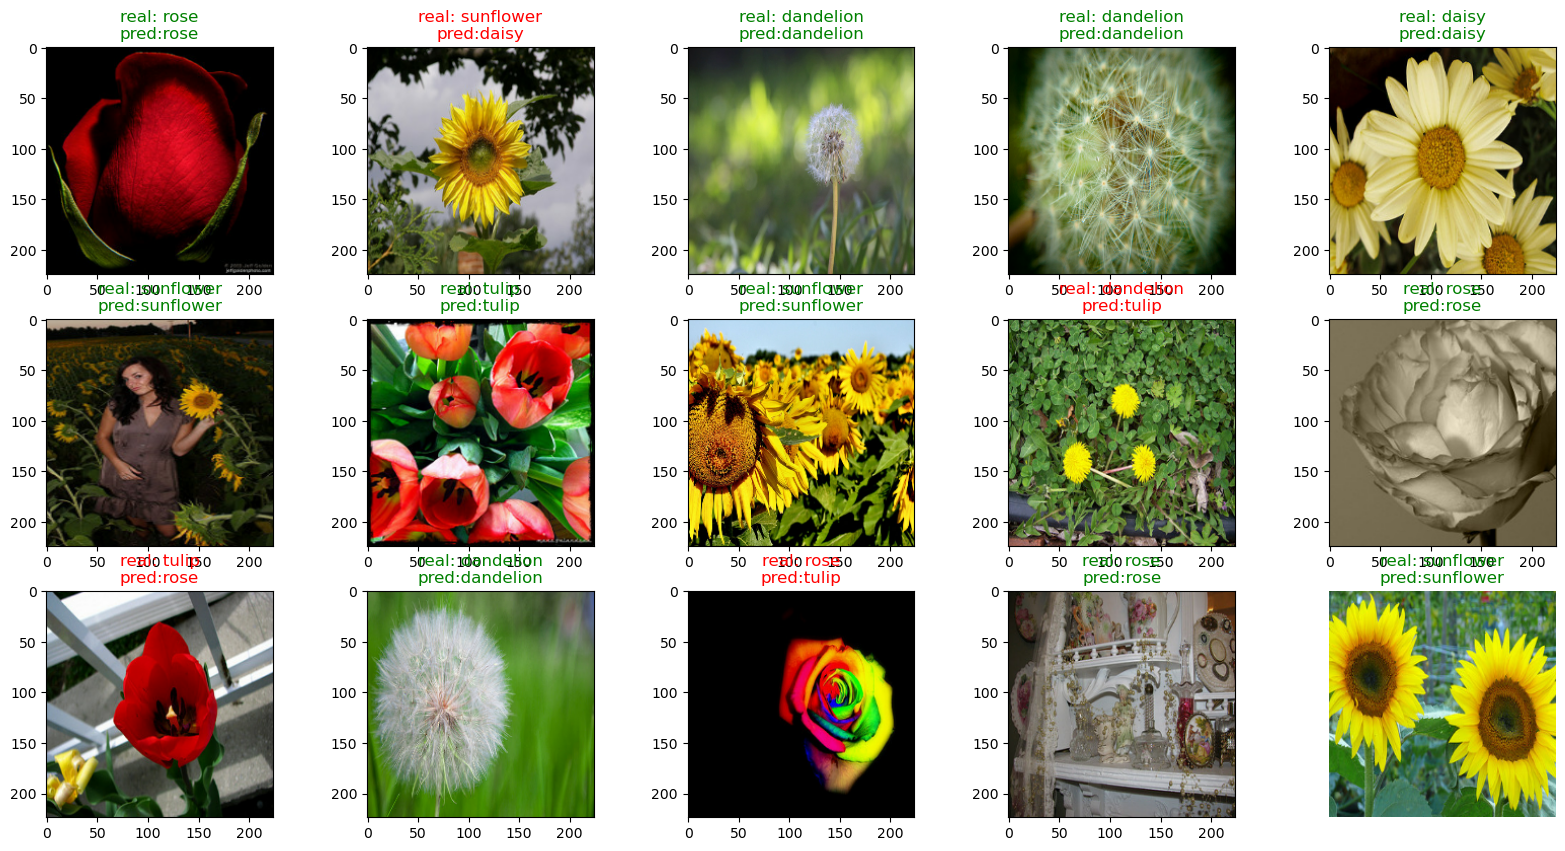

In [13]:
hf.plot_actual_prediction(baseline_model, categories, validation_set)

Model is not performing well. Accuracy is terrible (bias is high). And generalization is bad (variance is high). 

Since the model did not accurately predict the flowers, the model didn't learn key features that differentiates the flowers (categories).

Solutions:
<ul>
    <li> Data Augmentation </li>
         * Create new images by augmenting the images to expose the model to more images
    <li> Transfer Learning</li>
        * Use a working model that performs well for our task<br>
    <li> Get more data</li>
        * Find more data for the model
</ul>

In [14]:
training_set.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Data Augmentation

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[0]),
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(
      "horizontal_and_vertical", 
      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3)
  ),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

def prepare(ds, shuffle=False, augment=False):
  
#     # Resize and rescale all datasets.
#     ds = ds.map(
#         lambda x, y: (resize_and_rescale(x), y), 
#         num_parallel_calls=AUTOTUNE
#     )
    
#     print()

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE
        )
    
#     # Batch all datasets.
#     ds = ds.batch(BATCH_SIZE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds = prepare(training_set, shuffle=True, augment=True)
val_ds = prepare(validation_set)

In [ ]:
# Running the model

tf.keras.backend.clear_session()

start_time = time.time()

augment_model = get_baseline_model()

augment_history = augment_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

elasped_time = time.time() - start_time
model_elapsed_time['data_augmentation'] = elasped_time

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

2022-12-11 22:25:34.191248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-11 22:25:34.506010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-12-11 22:25:35.009130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/69 [======================>.......] - ETA: 5s - loss: 1.5308 - accuracy: 0.3238

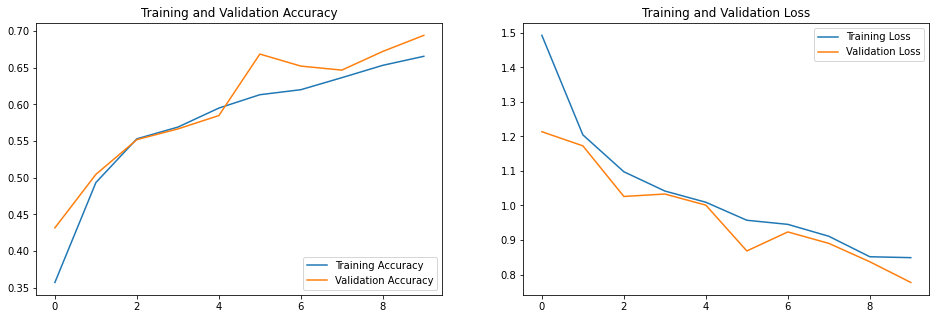

In [19]:
# Viewing the results of the training

hf.plot_history(augment_history)

The training and validation have similar accuracy and loss (low variance). However the accuracy is ~70% (high bias). If we would like, we can do more augmentation like random contrasting.

Next we will try transfer learning. Use a model that has a great track record classifying and apply it to our task.

## Transfer Learning

In [20]:
base_transfer_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SIZE+ (3,),
    include_top=False,
    weights='imagenet'
)

In [22]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_transfer_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 576)


In [23]:
base_transfer_model.trainable = False

In [24]:
base_transfer_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [25]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [26]:
# prediction_layer = tf.keras.layers.Dense(len(categories), activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [27]:
# IMG_RESIZE = 160

# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.Resizing(IMG_RESIZE, IMG_RESIZE),
#   tf.keras.layers.Rescaling(1./255)
# ])

# def prepare_transfer_learning_data(ds, shuffle=False):
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)
#     return ds.prefetch(buffer_size=AUTOTUNE)

In [29]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = tf.keras.layers.Resizing(IMG_RESIZE, IMG_RESIZE)(inputs)
x = base_transfer_model(inputs, training=False)
# x = tf.keras.layers.Conv2D()
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(categories), activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [ ]:
start_time = time.time()

transfer_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

elasped_time = time.time() - start_time
model_elapsed_time['transfer_model'] = elasped_time

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2885      
                                                                 
Total params: 942,005
Trainable params: 2,885
Non-trainable params: 939,120
_________________________________________________________________


In [ ]:
transfer_history = transfer_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

Epoch 1/10
65/69 [===========================>..] - ETA: 0s - loss: 1.1842 - accuracy: 0.5539

KeyboardInterrupt: 

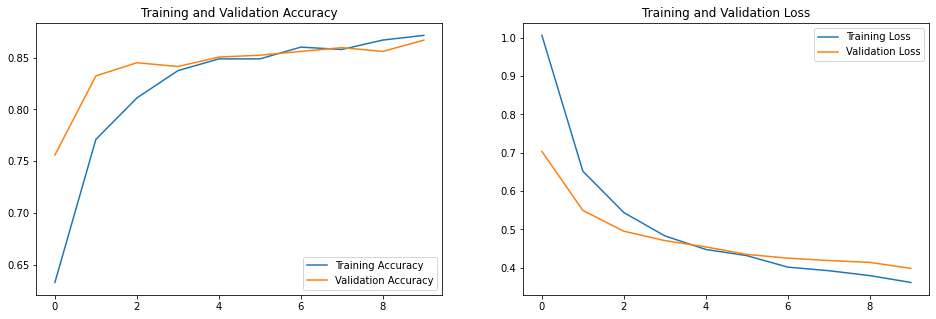

In [ ]:
hf.plot_history(transfer_history)